# Data Preparation 
- [reference:7-steps-mastering-data-preparation-python](http://www.kdnuggets.com/2017/06/7-steps-mastering-data-preparation-python.html?utm_content=buffere0216&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer)
 - Step 1: Preparing for the Preparation
 - Step 2: Exploratory Data Analysis
 - Step 3: Dealing with Missing Values
 - Step 4: Dealing with Outliers
 - Step 5: Dealing with Imbalanced Data
 - Step 6: Data Transformations
 - Step 7: Finishing Touches & Moving Ahead
 
 

# rentdatas
- [geo location](#rent-geo)
- [space](#rent-space)
- [rent](#rent)
- [cityID](#rent-cityID)
- [floor](#floor)

## [environment items](#environment)

In [1]:
import pymysql
import redis

#redis connection
#r = redis.StrictRedis(host='172.17.0.2', port=6379, db=0)

#connect maria rdb
db = pymysql.connect(
        host='172.17.0.4',
        user='root',
        passwd='1234',
        db='rental',
        charset='utf8mb4'
    )
#設置cursor
cursor = db.cursor()

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling

cursor.execute('SELECT ID, cityID, pet, rent, space , lat, lng , label, floor FROM rentInfo;')
#dtype_dict = { "rent":np.int32, "space":np.float64, "lat":np.float64, "lng":np.float64}
df = pd.DataFrame(list(cursor.fetchall()),
                 columns = ["ID", "cityID", "pet", "rent", "space", "lat", "lng","label","floor"])
cursor.close()
# df.columns = ["ID", "cityID", "pet", "rent", "space", "lat", "lng","label"]

In [3]:
df.dtypes

ID         int64
cityID     int64
pet       object
rent       int64
space     object
lat       object
lng       object
label     object
floor      int64
dtype: object

In [4]:
#轉換型態
df.loc[:,["space", "lat", "lng"]] = df.loc[:,["space", "lat", "lng"]].astype(np.float64)
df.dtypes

ID          int64
cityID      int64
pet        object
rent        int64
space     float64
lat       float64
lng       float64
label      object
floor       int64
dtype: object

In [5]:
df.shape

(24799, 9)

# rent geo
主要是一些因為過期等因素抓取失敗的  
Taipei + Newtaipei latlng range:
- lng:[121.29,122.00]  
- lat:[24.68,25.29]  

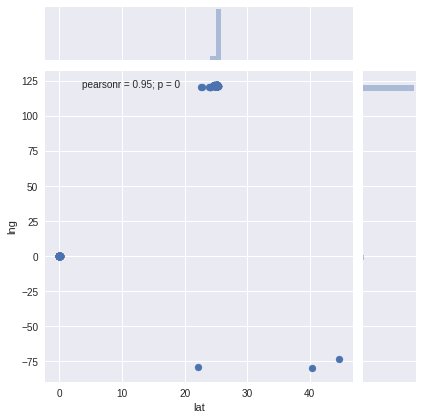

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
sns.jointplot(x="lat", y="lng", data=df);

In [7]:
#outline data
print(df.shape)
df = df[df.lng>121]
print(df.shape)
#check
print(df[df.lng<122].shape)
print(df[df.lat>24].shape)
print(df[df.lat<26].shape)

(24799, 9)
(24648, 9)
(24648, 9)
(24648, 9)
(24648, 9)


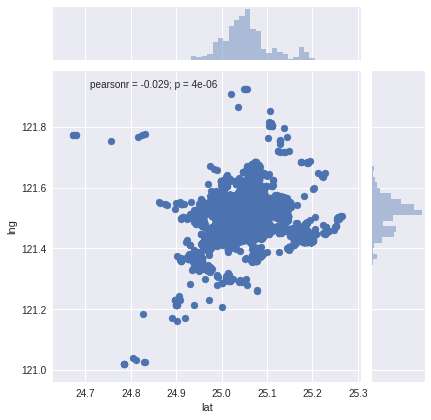

In [8]:
# sns.jointplot(x="lat", y="lng", data=df,
#               ylim=[121.0,122.00], xlim=[24.68,25.29]);
sns.jointplot(x="lat", y="lng", data=df);

# rent space

count    24648.000000
mean        25.570247
std        120.455045
min          0.000000
5%           0.000000
10%          4.000000
25%          6.000000
50%         14.795000
75%         36.000000
90%         58.750000
95%         75.168500
max      18000.000000
Name: space, dtype: float64

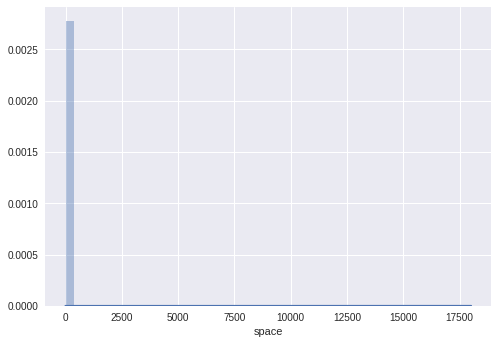

In [9]:
sns.distplot(df.space); df.space.describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.9, 0.95])

In [10]:
#檢查上下極值數量 
df[df.space<2].shape

(1814, 9)

In [11]:
df[df.space>97].shape

(480, 9)

In [12]:
df = df[df.space>=2]
df[df.space<2].shape

(0, 9)

In [13]:
df = df[df.space<=97]
df[df.space>97].shape

(0, 9)

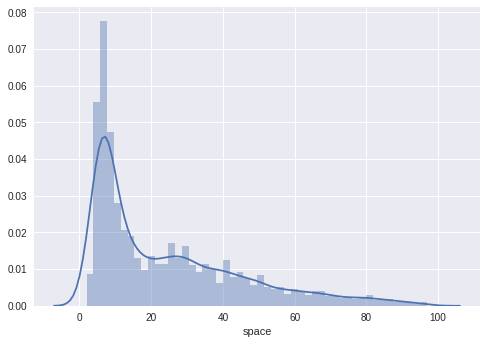

In [14]:
sns.distplot(df.space ,bins=50)

# rent 

count    2.235400e+04
mean     1.018385e+05
std      4.265367e+06
min      0.000000e+00
5%       5.000000e+03
10%      6.500000e+03
25%      9.000000e+03
50%      1.800000e+04
75%      3.500000e+04
90%      6.500000e+04
95%      8.800000e+04
max      5.000000e+08
Name: rent, dtype: float64

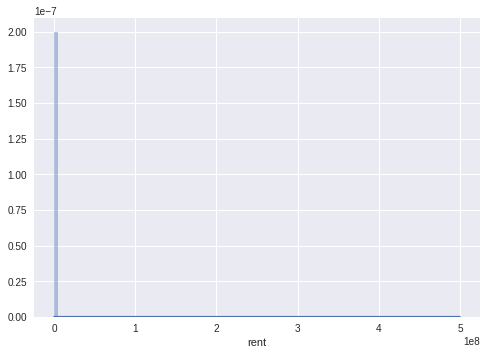

In [15]:
sns.distplot(df.rent ,bins=100); df.describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.9, 0.95]).rent

In [16]:
df[df.rent<2500].shape

(20, 9)

In [17]:
df[df.rent>120000].shape

(392, 9)

In [18]:
df = df[df.rent<=120000]
df[df.rent>120000].shape

(0, 9)

In [19]:
df = df[df.rent>2500]
df[df.rent<=2500].shape

(0, 9)

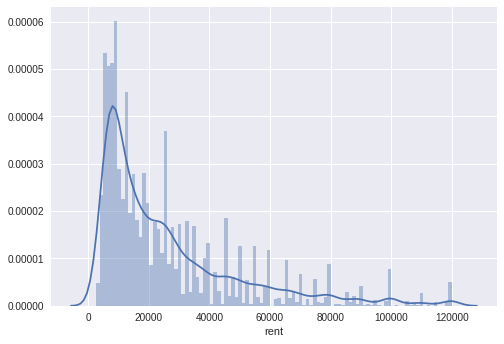

In [20]:
sns.distplot(df.rent ,bins=100);

In [21]:
#檢查 租金/坪數
df['unit'] = df["rent"].divide(df["space"])

count    21932.000000
mean      1256.348937
std        580.238631
min         75.075075
25%        875.000000
50%       1171.428571
75%       1555.634135
max      14400.000000
Name: unit, dtype: float64

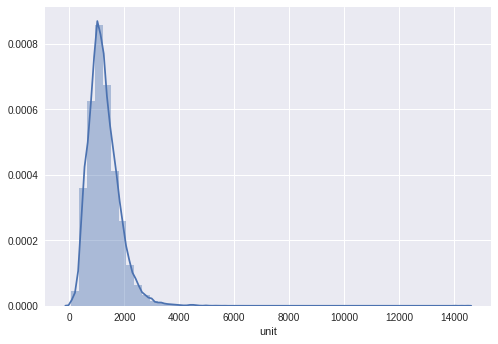

In [22]:
sns.distplot(df.unit); df.unit.describe()

In [23]:
df = df[df['unit']>=300]
df[df.unit<300].shape

(0, 10)

In [24]:
df = df[df['unit']<3500]
df[df.unit>3500].shape

(0, 10)

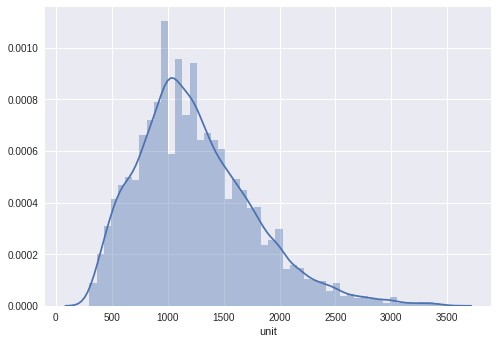

In [25]:
sns.distplot(df.unit)

# rent cityID
調整那些非3碼，和非台北新北

In [26]:
df.describe().cityID

count    21674.000000
mean       168.825828
std        183.679445
min        100.000000
25%        106.000000
50%        114.000000
75%        236.000000
max      10491.000000
Name: cityID, dtype: float64

In [27]:
#digit 5 => digit 3
import re
def idfilter(cityID):
    try:
        n = int(cityID)
        digit = n // 100
        if digit//100 < 1:
            return n
        else:
            return digit
    except:
        pass

df['cityID'] = df.cityID.map(idfilter)

In [28]:
df[df.cityID>253].shape

(61, 10)

In [29]:
#new taipei postal code max is 253
df = df[df.cityID<=253]
df[df.cityID>253].shape

(0, 10)

In [30]:
df.shape

(21613, 10)

# floor

count    21613.000000
mean         5.380882
std          4.291689
min         -2.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         56.000000
Name: floor, dtype: float64

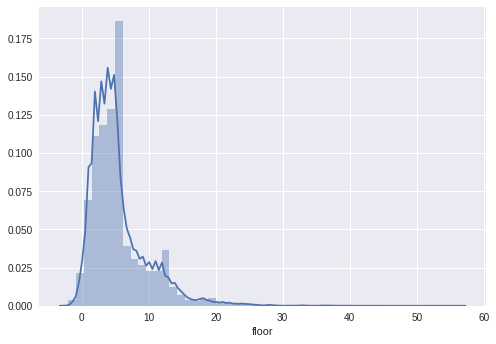

In [31]:
sns.distplot(df.floor); df.floor.describe()

In [32]:
df = df[df.floor<21]
df = df[df.floor>0]

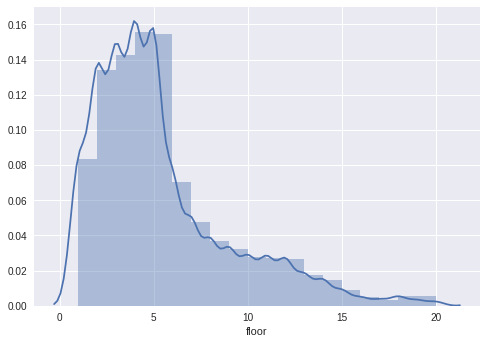

In [33]:
sns.distplot(df.floor, bins=19)

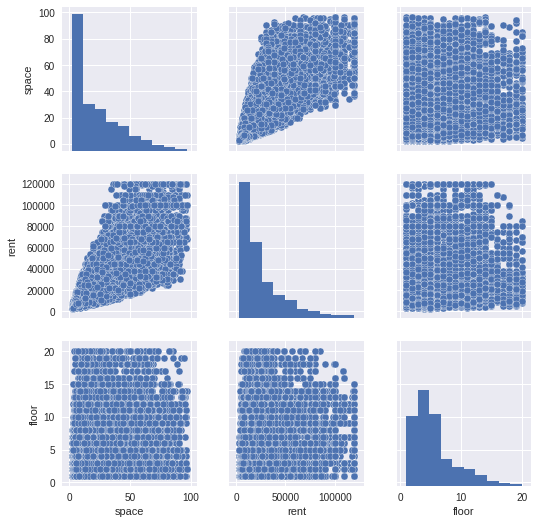

In [34]:
sns.pairplot(df.loc[:,['space', 'rent', 'floor']], diag_kind='hist')

In [35]:
df.head()

,ID,cityID,pet,rent,space,lat,lng,label,floor,unit
0,1,251,N,25000,62.34,25.181837,121.440487,住,5,401.026628
1,2,251,N,32000,50.70,25.197719,121.421685,住,2,631.163708
2,3,251,N,25000,44.97,25.178503,121.454991,住,9,555.926173
3,4,251,N,5000,7.00,25.170918,121.441836,套,4,714.285714
4,5,239,N,6000,7.99,24.974047,121.327134,套,3,750.938673


In [36]:
df.to_csv('./data/clear_rent_items.csv', encoding='utf-8', index=False)

# environment
- [geo](#env-geo)
- [cityID](#env-cityID)
- [food cost](#food-cost)

In [37]:
import pymysql
db = pymysql.connect(
        host='172.17.0.4',
        user='root',
        passwd='1234',
        db='rental',
        charset='utf8mb4'
    )
#設置cursor
cursor = db.cursor()
#cursor.execute('SELECT * FROM typeID;')

In [38]:
cursor.execute('SELECT * FROM typeID;')
typeid = cursor.fetchall()

In [39]:
cursor.execute('SELECT ID, cityID, typeID, cost , lat, lng  FROM `baseEnviro`;')

73829

In [40]:
import numpy as np
import pandas as pd
envdf = pd.DataFrame(list(cursor.fetchall()), columns=['ID', 'cityID', 'typeID', 'cost' ,'lat', 'lng'])
cursor.close()

In [41]:
envdf.dtypes

ID         int64
cityID     int64
typeID     int64
cost       int64
lat       object
lng       object
dtype: object

In [42]:
envdf.loc[:,['lat', 'lng']] = envdf.loc[:,['lat', 'lng']].astype(np.float64)

# env geo
[range](#rent-geo)

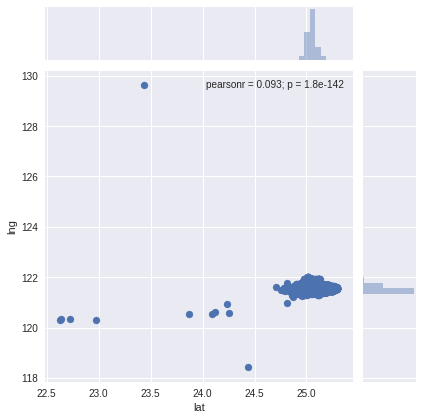

In [43]:
sns.jointplot(x="lat", y="lng", data=envdf);

In [44]:
envdf = envdf[envdf.lat>24.6]
envdf = envdf[envdf.lat<25.3]
envdf = envdf[envdf.lng<122]
envdf = envdf[envdf.lng>121]

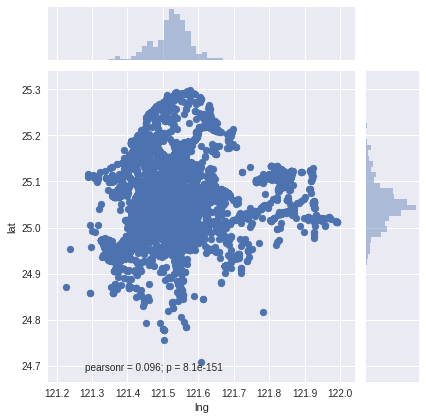

In [45]:
sns.jointplot(x="lng", y="lat", data=envdf);

# env cityID

In [46]:
envdf.cityID.describe()

count    73814.000000
mean       154.944726
std        176.623946
min        100.000000
25%        106.000000
50%        112.000000
75%        231.000000
max      10491.000000
Name: cityID, dtype: float64

In [47]:
envdf['cityID'] = envdf.cityID.map(idfilter)

In [48]:
envdf.cityID.describe()

count    73814.000000
mean       152.271073
std         60.742766
min        100.000000
25%        106.000000
50%        112.000000
75%        231.000000
max        710.000000
Name: cityID, dtype: float64

In [49]:
envdf = envdf[envdf.cityID<=253]

# food cost

In [50]:
foodf = envdf[envdf.typeID==101]

count    3.448200e+04
mean     1.274349e+04
std      2.312948e+06
min      1.100000e+01
25%      7.800000e+01
50%      1.500000e+02
75%      3.000000e+02
max      4.294970e+08
Name: cost, dtype: float64

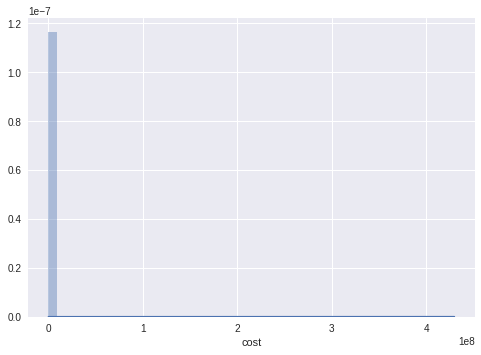

In [51]:
sns.distplot(foodf.cost);foodf.cost.describe()

In [52]:
foodf = foodf[foodf.cost<=1200]
foodf = foodf[foodf.cost>5]

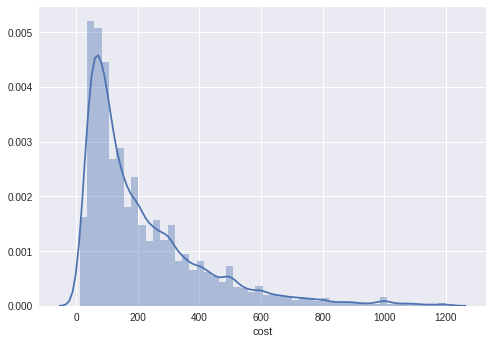

In [53]:
sns.distplot(foodf.cost)

In [54]:
# merge
tmpdf = envdf.drop(envdf[envdf.typeID==101].index)

newdf = pd.concat([foodf,tmpdf], axis=0,ignore_index=True)

newdf.to_csv('./data/clear_env_items.csv', encoding='utf-8', index=False)